In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))

# Any results you write to the current directory are saved as output.

['working', 'lib', 'config', 'input']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
bs=64

In [5]:
!mkdir data

In [6]:
mycsv=pd.read_csv("../input/train.csv")
mycsv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
!mkdir ./data/train
!mkdir ./data/train/1
!mkdir ./data/train/0
for i in mycsv.values:
    shutil.copy("../input/train/train/"+i[0],"./data/train/"+str(i[1])+"/"+i[0])

In [8]:
path=Path('./data')

In [9]:
data= ImageDataBunch.from_folder(path,train="./train",valid_pct=0.2,ds_tfms=get_transforms(),size=bs,num_workers=0).normalize(imagenet_stats)

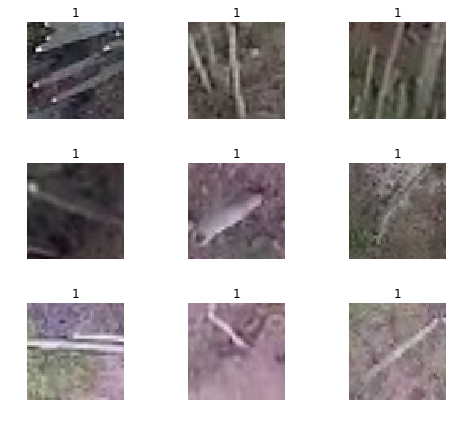

In [10]:
data.show_batch(rows=3,figsize=(7,6))

In [ ]:
#!mkdir ../test
#for file in os.listdir('../input/test/test'):
    #shutil.copy('../input/test/test/'+file,'../test/'+file)

In [17]:
data.classes

['0', '1']

In [11]:
learn=create_cnn(data,models.resnet34, metrics=error_rate)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:05, 16439031.49it/s]


In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


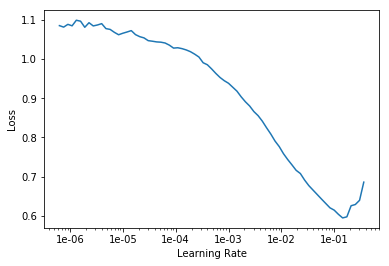

In [14]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.207058,0.091498,0.036857,00:36
1,0.102791,0.057572,0.021429,00:37
2,0.077940,0.038632,0.015714,00:36
3,0.061332,0.035383,0.015143,00:37


In [35]:
interp= ClassificationInterpretation.from_learner(learn)
losses,indxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(indxs)

True

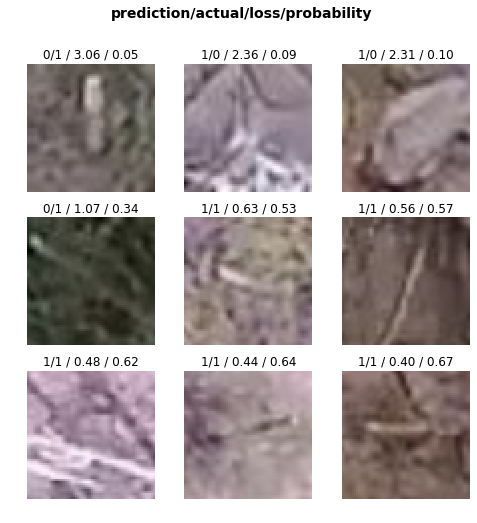

In [36]:
interp.plot_top_losses(9, figsize=(8,8))

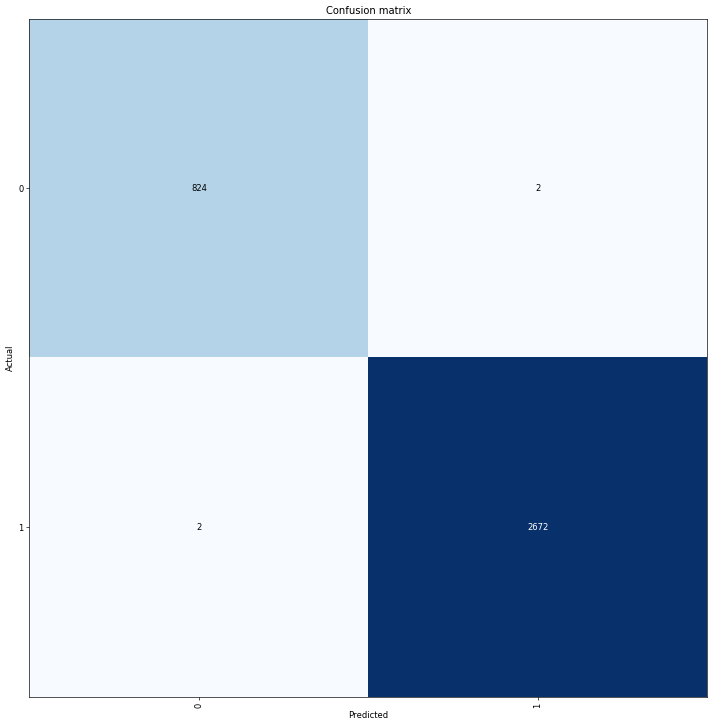

In [37]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [23]:
learn.save('stage-1')

In [ ]:
!cd data/models && ls

In [ ]:
os.listdir('../input/test/test/')[0]

In [ ]:
img=open_image("../input/test/test/c662bde123f0f83b3caae0ffda237a93.jpg")

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-4,1e-2))
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.057476,0.015137,0.005714,00:39
1,0.016446,0.005448,0.001143,00:39


In [25]:
data2= ImageDataBunch.single_from_classes(path,["0","1"],ds_tfms=get_transforms(),size=64).normalize(imagenet_stats)

In [34]:
learn=create_cnn(data2,models.resnet34).load('stage-2')

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [27]:
mydf={'id':[],'has_cactus':[]}
for i in os.listdir('../input/test/test'):
    img=open_image("../input/test/test/"+i)
    pred_class, pred_idxs, outputs = learn.predict(img)
    mydf['id'].append(i)
    mydf['has_cactus'].append(pred_class)


In [ ]:
mydf=pd.DataFrame(mydf)
mydf.head()

In [ ]:
file=mydf.to_csv('test.csv',sep=',',index=False)

In [ ]:
!rm -r ./data

In [ ]:
from IPython.display import FileLink
FileLink('test.csv')